In [1]:
import numpy as np 
from TRIOMA.tools.Circuit import Circuit
from TRIOMA.tools.Extractors.PAV import Component,Fluid,Membrane, Geometry
import TRIOMA.tools.correlations as corr
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
from TRIOMA.tools.BreedingBlanket import BreedingBlanket

This analysis is a sweep on two parameters and the analytical efficiency value from it. First we define the d_hyd_v, the first sweep vector. This is going to be sweeped against all others (otherwise the analysis would be very long if we sweep all vectors against each other). Then we define a vector of vectors to sweep. A str_v_vec is used in the "update_attribute" method to indicate which attribute is going to be updated, corresponding with the vector that is sweeped in the loop. The Fluid_v_bool vector is used in this code to check if the update attribute must be used for the Component class or the Component.fluid class. The same happens for the solid_v_bool. Color vectors will be used after for plotting contours. Eff_v_vec is used then to store the results.

In [2]:
##Define sweep vectors
color_vector = ["red", "blue", "green", "yellow", "purple", "orange"]
N_vec=50
# d_hyd_v=np.logspace(np.log10(2.5E-2/2),np.log10(2.5E-2*2),N_vec)
d_hyd_v=np.linspace(9.2E-3,2.5E-2*2,N_vec)
n_pipes_vec=np.linspace(2000,8000,N_vec)
# str_v_vec=['T','U0','Solubility','c_in',"thick","K_S","k_d","k_r"]
variables={'d_Hyd':'Hydraulic Diameter [m]','n_pipes':'Number of Pipes'}
# variables = {'T' : 'Temperature [K]', 'U0' : 'Velocity [m/s]', 'Solubility' : 'Solubility [mol/m^3]', 'c_in' : 'Concentration [mol/m^3]', 'thick' : 'Thickness [m]', 'K_S' : 'Partition Coefficient', 'k_d' : 'Desorption Rate [1/s]', 'k_r' : 'Reaction Rate [1/s]'}
c_in_vec=np.logspace(-6,-1,N_vec)
D_vec=np.logspace(-10,-8,N_vec)
thick_vec=np.logspace(-3,-1,N_vec)
K_S_vec=np.logspace(-3,-1,N_vec)
k_d_vec=np.logspace(2,6,N_vec)
k_r_vec=np.logspace(2,6,N_vec)
solubility_vec=np.logspace(-3,-1,N_vec)
# v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec,  thick_vec, K_S_vec])
v_vec=np.array([d_hyd_v])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , False , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])

Here variables for the Breeding Blanket class are defined. 

In [3]:
#Define other HX constraints

T_hot_prim=900
T_hot_sec=838
T_cold_prim=800
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*(T_sec_ave-273.15)+3.49E-7*(T_sec_ave-273.15)**2-1.474E-10*(T_sec_ave-273.15)**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=2
Q=0.625E9
m_in_sec=Q/(cp_sec*(T_hot_sec-T_cold_sec))
n_pipes_HX=4000

Empty arrays to store results with the append method are defined, and the double sweep takes place. In each iteration, the same component is defined and then one attribute is changed according to the sweep. Then color map plots are displayed, with additional isovariable contours.  

2025.386635865169 indicates laminar flow
1999.6958495144274 indicates laminar flow
1966.3947921021054 indicates laminar flow
2011.2210722639497 indicates laminar flow
1976.574129286256 indicates laminar flow
1943.1006839621323 indicates laminar flow
1910.7421093067626 indicates laminar flow
2026.9254445700262 indicates laminar flow
1990.7620030191872 indicates laminar flow
1955.866363853016 indicates laminar flow
1922.173006461864 indicates laminar flow
1889.620848623725 indicates laminar flow
1858.1528769405215 indicates laminar flow
2009.1299047501614 indicates laminar flow
1972.6327987333282 indicates laminar flow
1937.4380207954594 indicates laminar flow
1903.4770862498099 indicates laminar flow
1870.6862295030637 indicates laminar flow
1839.0060044641607 indicates laminar flow
1808.3809248796147 indicates laminar flow
1993.6029094797493 indicates laminar flow
1956.7178202784182 indicates laminar flow
1921.172812679416 indicates laminar flow
1886.8961593834038 indicates laminar flo

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_23112\89788373.py:87: UserWarning: Log scale: values of z <= 0 have been masked
  contour1=plt.contour(X, Y, Z, levels=np.linspace(np.nanmin(Z), np.nanmax(Z), 7), norm=LogNorm(), colors=color_vector[0])


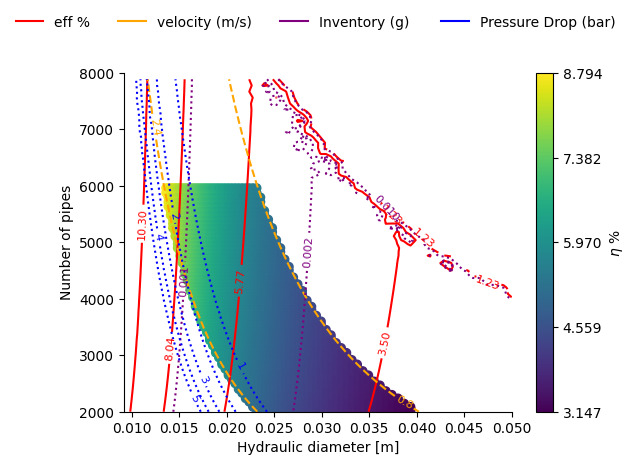

In [4]:
from matplotlib import contour


for j,vec in enumerate(v_vec):
        eff_v=np.array([])
        var_str=list(variables.keys())[j]
        T=800
        res_vec=np.array([])
        d_hyd_v_res=np.array([])
        n_pipes_v_res=np.array([])
        deltap_vec=np.array([])
        L_vec=np.array([])
        U0_v=np.array([])
        inv_v=np.array([])
        res_vec=np.array([])
        power_v=np.array([])
        for n_pipes in n_pipes_vec:
                for i,d_hyd in enumerate(d_hyd_v):
                        mat=materials.Flibe(T)
                        flibe=Fluid(T=T, Solubility=mat.Solubility, MS=False,D=mat.D, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1,k=mat.k,
                         cp=mat.cp)
                        BB=BreedingBlanket(Q=Q,TBR=1.08,T_out=T_hot_prim,T_in=T_cold_prim,fluid=flibe, c_in=1E-10 )
                        BB.get_flowrate()
                        BB.get_cout()
                        c0=BB.c_out
                        Steel = Membrane( T=T,
                                D=1E-6,
                                # D=1E-4,
                                thick=2.1E-3,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        Steel_HX = Membrane( T=T,
                                D=1E-9,
                                # D=1E-4,
                                thick=2.1E-3,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        geom_PAV=Geometry(thick=2.1E-3, D=d_hyd,L=15,n_pipes=n_pipes)
                        geom_HX=Geometry(thick=2.1E-3, D=2.5E-2, L=10, n_pipes=n_pipes_HX)
                        PAV = Component(c_in=c0, geometry=geom_PAV, fluid=flibe, membrane=Steel)
                        PAV.fluid.update_attribute('U0',BB.m_coolant/(PAV.fluid.rho*PAV.geometry.n_pipes*PAV.fluid.d_Hyd**2/4)/N_HX)
                        Q_HX=Q/n_pipes_HX/N_HX
                        flibe_HX=Fluid(T=T, Solubility=mat.Solubility, MS=False,D=mat.D, d_Hyd=2.5E-2 ,mu=mat.mu,rho=mat.rho,U0=2.5,k=mat.k,cp=mat.cp)
                        HX=Component(c_in=1, fluid=flibe_HX, membrane=Steel_HX, geometry=geom_HX)
                        # PAV.get_adimensionals()
                        d_h_sec=2.5E-2 
                        V_sec=m_in_sec/(rho_sec*d_h_sec**2*np.pi/4)/N_HX/n_pipes_HX
                        Re_sec=corr.Re(rho=rho_sec,u=V_sec,mu=mu_sec,L=d_h_sec)
                        Pr_sec=corr.Pr(c_p=cp_sec,mu=mu_sec,k=k_sec)
                        h_coeff_sec=corr.get_h_from_Nu(corr.Nu_DittusBoelter(Re_sec, Pr_sec), k_sec,d_h_sec)
                        R_sec=1/h_coeff_sec
                        U = HX.get_global_HX_coeff(R_conv_sec=R_sec)
                        L= corr.get_length_HX(corr.get_deltaTML(T_hot_prim, T_cold_prim, T_cold_sec, T_hot_sec), HX.fluid.d_Hyd, HX.U, Q_HX)
                        HX.geometry.update_attribute('L',L)
                        FC=Circuit(components=[BB,PAV, HX],closed=True)
                        FC.solve_circuit()
                        out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        eff_v=np.append(eff_v, PAV.eff)
                        d_hyd_v_res=np.append(d_hyd_v_res, d_hyd)
                        n_pipes_v_res=np.append(n_pipes_v_res, n_pipes)
                        res_vec=np.append(res_vec, PAV.eff)
                        L_vec=np.append(L_vec, L)
                        U0_v=np.append(U0_v, PAV.fluid.U0)
                        PAV.get_pumping_power()  
                        PAV.get_pressure_drop()
                        deltap_vec=np.append(deltap_vec, PAV.delta_p/1E5)
                        FC.get_inventory(flag_an=True)
                        power_v=np.append(power_v, PAV.pumping_power)
                        inv_v=np.append(inv_v, FC.inv*9)
                eff_v_vec=np.append(eff_v_vec, eff_v)
        plt.figure(j)
        plt.xlabel('Hydraulic diameter [m]')
        plt.ylabel('Number of pipes')
        x = np.logspace(np.log10(min(d_hyd_v_res[:])), np.log10(max(d_hyd_v_res[:])), num=100)
        y = np.logspace(np.log10(min(n_pipes_v_res[:])), np.log10(max(n_pipes_v_res[:])), num=100)
        X, Y = np.meshgrid(x, y)
        Z = griddata((d_hyd_v_res, n_pipes_v_res), (res_vec)*100, (X, Y), method='cubic')
        dZdX, dZdY = np.gradient(Z, x, y, edge_order=2)
        ZL=griddata((d_hyd_v_res, n_pipes_v_res), L_vec, (X, Y), method='cubic')
        Z_U0=griddata((d_hyd_v_res, n_pipes_v_res), U0_v, (X, Y), method='cubic')
        Zpower=griddata((d_hyd_v_res, n_pipes_v_res), power_v, (X, Y), method='cubic')
        Zinv=griddata((d_hyd_v_res, n_pipes_v_res), inv_v, (X, Y), method='cubic')
        Z_deltap=griddata((d_hyd_v_res, n_pipes_v_res), deltap_vec, (X, Y), method='cubic')
        Z_npipes=griddata((d_hyd_v_res, n_pipes_v_res), n_pipes_v_res, (X, Y), method='cubic')
        contour1=plt.contour(X, Y, Z, levels=np.linspace(np.nanmin(Z), np.nanmax(Z), 7), norm=LogNorm(), colors=color_vector[0])
        contour3=plt.contour(X, Y, Z_U0, levels=np.linspace(0.8, 2.4, 2), colors=color_vector[5], linestyles='dashed')
        # contour7=plt.contour(X, Y, Zpower, levels=np.linspace(1E5, 1E6, 2), colors=color_vector[1], linestyles='dotted')
        contour8=plt.contour(X, Y, Zinv, levels=[1E-3,2E-3,1E-2,1E-1,1], colors=color_vector[4], linestyles='dotted')
        contour4=plt.contour(X, Y, Z_deltap, levels=np.linspace(1, 5, 5), colors=color_vector[1], linestyles='dotted')
        ## add mask for a range of values
        mask = (Z_U0 > 2.4) | (Z_U0 < 0.8) | (Zpower > 0.8E6) | (Z_npipes < 2000) | (Z_npipes > 6000) |(Z_deltap>3E5)
        Z[mask] = np.nan
        scatter=plt.scatter(X,Y, c=Z ) #,norm=colors.LogNorm() 
        plt.clabel(contour1, inline=True, fontsize=8)
        plt.clabel(contour3, inline=True, fontsize=8)
        # plt.clabel(contour7, inline=True, fontsize=8)
        plt.clabel(contour8, inline=True, fontsize=8)
        plt.clabel(contour4, inline=True, fontsize=8)
        if scatter:
                if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                        cbar = plt.colorbar(scatter, ticks=np.linspace(np.nanmin(scatter.get_array()), np.nanmax(scatter.get_array()), 5))  # Show color scale for scatter with 5 ticks
                        cbar.set_label(r'$\eta$ %')
                else:
                        print("Cannot create colorbar: data does not have a valid range of values.")
        line1 = mlines.Line2D([], [], color=color_vector[0], markersize=15, label='eff %')
        line3 = mlines.Line2D([], [], color=color_vector[5], markersize=15, label='velocity (m/s)')
        # line7= mlines.Line2D([], [], color=color_vector[1], markersize=15, label='Pumping Power (W)')
        line8= mlines.Line2D([], [], color=color_vector[4], markersize=15, label='Inventory (g) ')
        line9= mlines.Line2D([], [], color=color_vector[1], markersize=15, label='Pressure Drop (bar) ')
        plt.legend(handles=[line1, line3, line8,line9], bbox_to_anchor=(0.5, 1.15), loc='center', ncol=4, frameon=False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.tight_layout()
        plt.savefig('feasibility_map_.png', dpi=300)
        
        plt.show()